<h1><center><font size="25">Exploración de la Calidad del aire en Madrid</font></center></h1>

<center><b>Ana Georgina Flesia </b></center>
    
  <center><b>  Basado en una notebook de Nicholas Holloway</b></center>

<center><i>19 de noviembre 2022 </i></center>



### Mission



El modelado de series de tiempo es un proceso de descomposición y representación de las relaciones estadísticas entre puntos de datos en el tiempo. Para que nuestro modelo se ajuste a nuestros datos y pronostique razonablemente, existen restricciones sobre las relaciones estadísticas en los datos que deben cumplirse. Esta notebook es una introducción al modelado de series de tiempo, la estacionariedad y cómo podemos descomponer y probar las relaciones estadísticas en nuestros datos antes de aplicar un modelo.

In [9]:
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline 

In [10]:
path = 'csvs_per_year/csvs_per_year'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in files), sort=False)
df = df.groupby(['date']).agg('mean')
df.index = pd.DatetimeIndex(data= df.index)

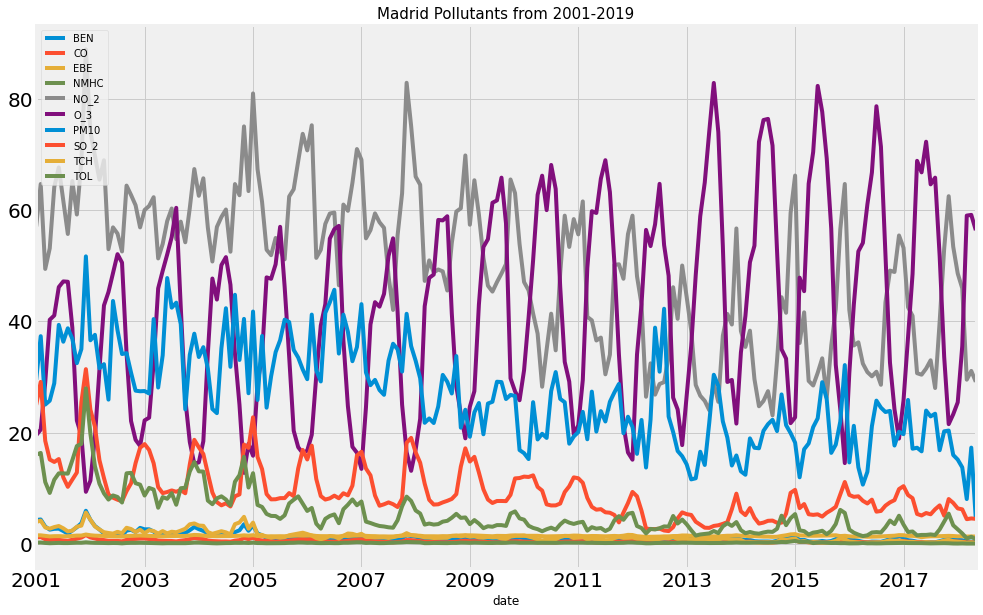

In [11]:
'''
['CH4', 'MXY', 'NO', 'NOx', 'OXY', 'PM25', 'PXY'] 
Have been removed because they were missing large potions of data
'''
col_list = ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'O_3', 'PM10', 'SO_2', 'TCH', 'TOL']
monthly_df = df.resample('M').mean()
daily_df = df.resample('D').mean()

plt_monthly = monthly_df[col_list]
plt_monthly.plot(figsize=(15, 10))
plt.title('Madrid Pollutants from 2001-2019', fontsize=15)
plt.legend(loc='upper left')
plt.show()

<a id='stationarity'></a>
# Estacionaridad

Una serie temporal estacionaria es aquella cuyas propiedades estadísticas, como la media, la varianza y la autocovarianza, son todas constantes y no una función del tiempo.

Si podemos suponer que estas propiedades estadísticas no cambiarán con el tiempo, entonces podemos predecir que el futuro de la serie temporal tendrá las mismas propiedades estadísticas o proporcionales. 

Como resultado, la mayoría de los métodos estadísticos de predicción se basan en la suposición de que la serie temporal es aproximadamente estacionaria, pero la mayoría de las series temporales que veremos no lo son.

Los no estacionarios pueden provenir de cambios deterministas como la tendencia o las fluctuaciones estacionales, o porque las propiedades estocásticas del proceso tienen una raíz unitaria. En el primer caso podemos eliminar el componente determinístico, y en el segundo podemos probar la presencia de la raíz unitaria y diferenciarla. 

En esta notebook explorará algunas de las principales formas en que podemos descomponer, probar y procesar nuestra serie de tiempo. Encontrar la secuencia de transformaciones necesarias para estacionarizar una serie de tiempo a menudo brinda pistas importantes en la búsqueda de un modelo de pronóstico apropiado.


<a id='unit root'></a>
### Unit Root
 
Las raíces unitarias son una de las causas de la no estacionariedad y es importante enterder porqué. Un proceso estocástico lineal tiene una raíz unitaria si el valor de la raíz de la ecuación característica del proceso es igual a 1. En una serie de tiempo, una raíz unitaria provoca una tendencia estocástica, a veces denominada caminata aleatoria con deriva. 

Presentaremos dos test de estacionaridad muy usados. 

<a id='adf'></a>
#### Augmented Dickey-Fuller
 
La hipótesis nula para esta prueba es que existe una raíz unitaria. La hipótesis alternativa es que la serie temporal es estacionaria o estacionaria en tendencia. Si el estadístico de prueba es menor que el valor crítico, podemos rechazar la hipótesis nula y decir que la serie es estacionaria. Además, si el valor de p es menor que alfa, podemos rechazar la hipótesis nula.
<a id='kpss'></a>
#### KPSS


KPSS determina si una serie temporal es estacionaria en torno a una tendencia media o lineal. La hipótesis nula es que los datos son estacionarios, la hipótesis alternativa para la prueba es que los datos no son estacionarios.

Para interpretar, si el estadístico de prueba es mayor que los valores críticos, entonces se rechaza la hipótesis nula y la serie es no estacionaria. También podemos usar el valor p devuelto y compararlo con el nivel alfa, donde si el valor p es menor que nuestro alfa, rechazamos la hipótesis nula.

Si no rechazamos la hipótesis nula, significa que nuestra serie de tiempo es estacionaria o estacionaria en tendencia, porque KPSS clasifica una serie como estacionaria en ausencia de una raíz unitaria.

Debido a que hay varios tipos de estacionaridad, podemos usar KPSS y ADF en conjunto para determinar qué transformaciones hacer. Si KPSS = Estacionario y ADF = No estacionario, nuestra serie de tiempo es estacionaria en tendencia y debemos eliminar la tendencia para que sea estrictamente estacionaria. Si KPSS = No estacionario y ADF = Estacionario, entonces nuestra serie de tiempo es estacionaria en diferencia y necesitamos diferenciar nuestra serie.


<a id='to stationarity'></a>
## Towards Stationary
Ahora que sabemos qué es estacionario y cómo probarlo, así es como podemos crear una serie estacionaria, salvo componentes estacionales y deterministas fuertes, que veremos más adelante. Dos prácticas comunes son la transformación y la diferenciación de Box-Cox.

<a id='box-cox'></a>
#### Box-Cox Transformation

Si nuestra serie de tiempo tiene una tendencia cuadrática subyacente, podríamos tomar la raíz cuadrada y hacerla lineal, acercando los datos un paso más a lo estacionario, para eso sirve una transformación de Box-Cox. Una transformación de Box-Cox intenta encontrar la transformación de potencia apropiada para hacer que nuestros datos sean más lineales y más normalmente distribuidos. Si nuestros datos parecen tener una tendencia de potencia, entonces son buenos candidatos para una transformación de Box-Cox. Podemos pasar a Box-Cox un argumento para lambda, el parámetro de transformación, para realizar una transformación de potencia o podemos pasar ningún argumento y automáticamente estimarà y devolverá un valor lambda.
* lambda = -1. es una transformada recíproca.
* lambda = -0.5 es una transformada de raíz cuadrada recíproca.
* lambda = 0.0 es una transformación logarítmica.
* lambda = 0.5 es una transformación de raíz cuadrada.
* lambda = 1.0 no es ninguna transformación.

Podemos probar la normalidad de varias maneras:
*Shapiro-Wilk
* Jarque-Bera: comprueba la curtosis y la asimetría frente a una distribución normal
* Gráfica Q-Q (Cuantil-Cuantil): Se puede usar una gráfica de los cuantiles de dos distribuciones
La normalidad no es necesaria para la estacionariedad pero lo es para muchos otros modelos y técnicas.


In [12]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('Null Hypothesis: Unit Root Present')
    print('Test Statistic < Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print (dfoutput, '\n')

def kpss_test(timeseries, regression='c'):
    # Whether stationary around constant 'c' or trend 'ct
    print ('Results of KPSS Test:')
    print('Null Hypothesis: Data is Stationary/Trend Stationary')
    print('Test Statistic > Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    kpsstest = kpss(timeseries, regression=regression)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}'] = value
    print (kpss_output, '\n')

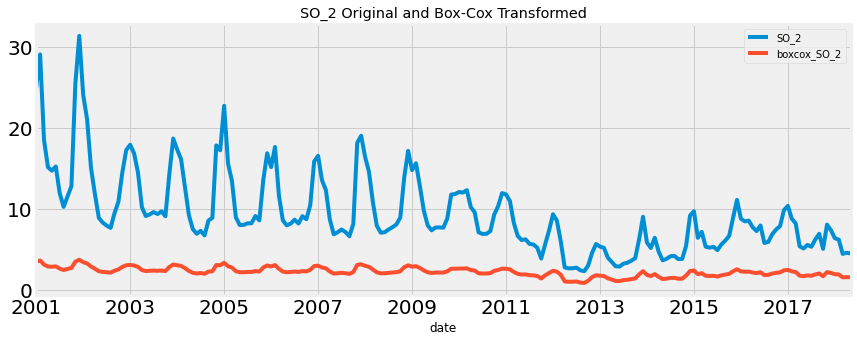

In [13]:
sta_so2_df = pd.DataFrame(monthly_df.SO_2)
sta_so2_df['boxcox_SO_2'], lamda = boxcox(sta_so2_df.SO_2)
sta_so2_df.plot(figsize=(13, 5), title='SO_2 Original and Box-Cox Transformed')
plt.show()



In [14]:
print('Box-Cox Lambda Value: ', lamda)

Box-Cox Lambda Value:  0.04372700552808493


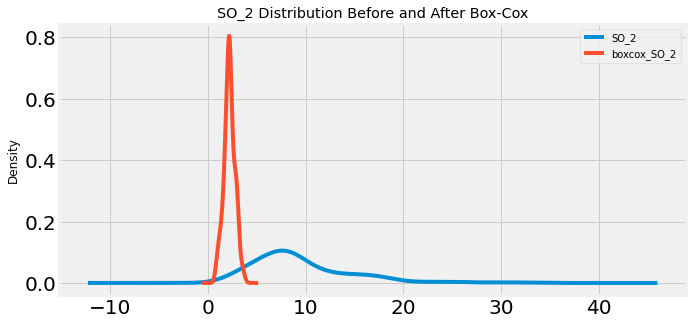

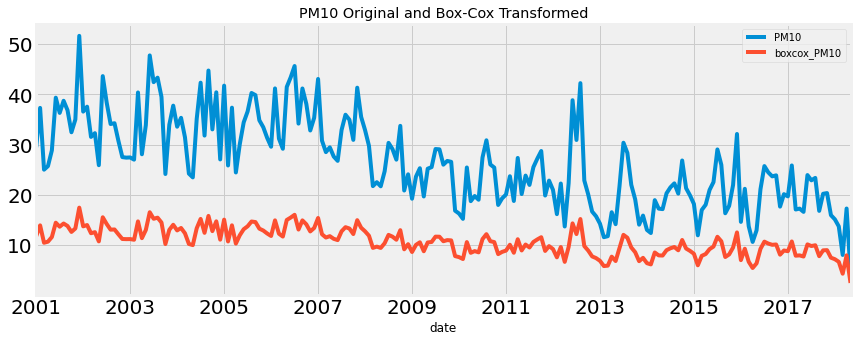

In [15]:
sta_so2_df.plot.kde(figsize=(10, 5), title= 'SO_2 Distribution Before and After Box-Cox')
plt.show()
sta_pm10_df = pd.DataFrame(monthly_df.PM10)
sta_pm10_df['boxcox_PM10'], pm_lamda = boxcox(sta_pm10_df.PM10)
sta_pm10_df.plot(figsize=(13, 5), title='PM10 Original and Box-Cox Transformed')
plt.show()



In [16]:
print('Box-Cox Lambda Value: ', pm_lamda)

Box-Cox Lambda Value:  0.6302082199887499


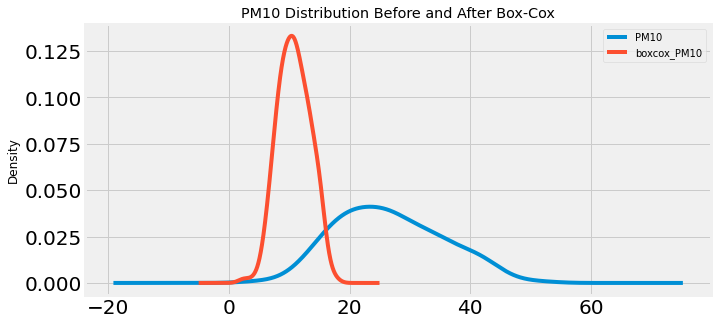

In [17]:
sta_pm10_df.plot.kde(figsize=(10, 5), title= 'PM10 Distribution Before and After Box-Cox')
plt.show()

<a id='differencing'></a>
#### Differencing


Diferenciar es restar una observación de una observación en el paso de tiempo anterior. La diferenciación genera una serie de tiempo de los cambios entre los puntos de datos sin procesar y nos ayuda a crear una serie de tiempo que es estacionaria. Normalmente, la cantidad correcta de diferenciación es el orden más bajo de diferenciación que produce una serie de tiempo que fluctúa alrededor de un valor medio bien definido y cuyo gráfico de función de autocorrelación (ACF) decae con bastante rapidez a cero. Después de cada operación de diferenciación, como la que realizamos a continuación, podemos realizar una prueba de Dickey-Fuller aumentada (adf) y Kwiatkowski-Phillips-Schmidt-Shin (kpss) para verificar la estacionariedad.

<AxesSubplot:title={'center':'SO_2 Original and Stationary'}, xlabel='date'>

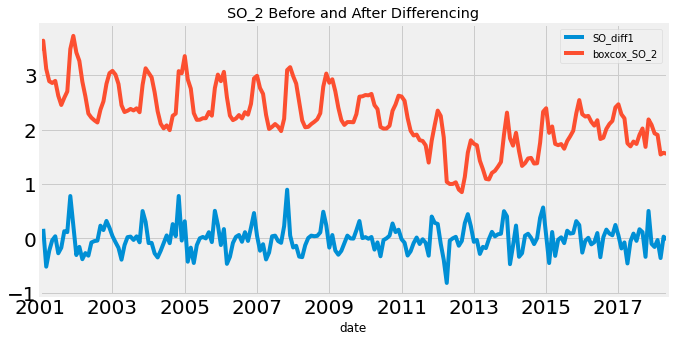

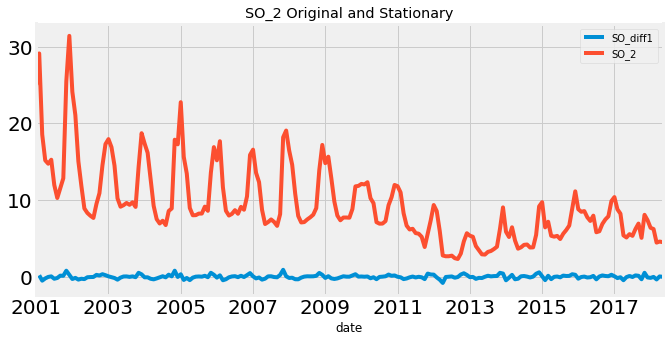

In [18]:
sta_so2_df['SO_diff1'] = sta_so2_df['boxcox_SO_2'].diff()
sta_so2_df.SO_diff1.dropna(inplace=True)

sta_so2_df[['SO_diff1', 'boxcox_SO_2']].plot(figsize=(10, 5), title='SO_2 Before and After Differencing')
sta_so2_df[['SO_diff1', 'SO_2']].plot(figsize=(10, 5), title='SO_2 Original and Stationary')

<AxesSubplot:title={'center':'PM10 Original and Stationary'}, xlabel='date'>

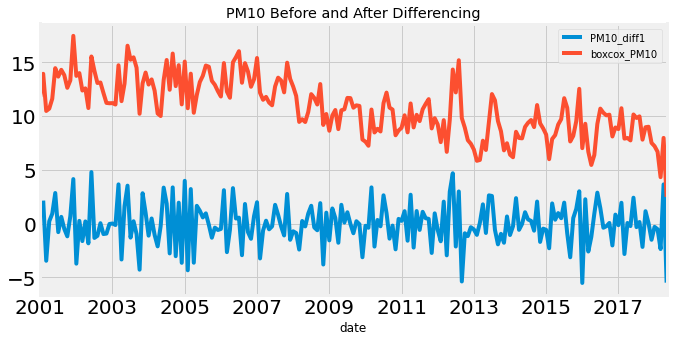

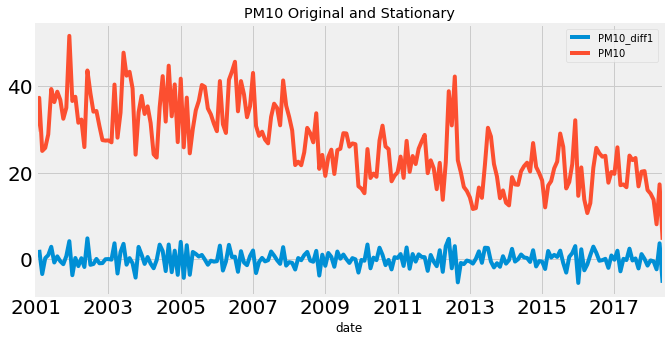

In [19]:
sta_pm10_df['PM10_diff1'] = sta_pm10_df['boxcox_PM10'].diff()
sta_pm10_df.PM10_diff1.dropna(inplace=True)

sta_pm10_df[['PM10_diff1', 'boxcox_PM10']].plot(figsize=(10, 5), title='PM10 Before and After Differencing')
sta_pm10_df[['PM10_diff1', 'PM10']].plot(figsize=(10, 5), title='PM10 Original and Stationary')

<a id='seasonality'></a>
# Seasonality
---
<a id='decomposition'></a>
### Seasonality Decomposition


Seasonality decompostion is an analysis tool that provides us a framework for how to think about the different components of our time series. We can decompose our series to understand the influence of each component and use that to guide our data preparation, model selection, and model tuning. As we saw in the section on exponential smoothing, models that consider seasonality versus those that don't have a prominent effect on our ability to forecast the series. 

Podemos pensar en nuestra serie temporal como compuesta por una combinación de nivel, tendencia, estacionalidad y ruido.

- nivel: El valor promedio de la serie
- tendencia: El valor creciente o decreciente en la serie
- estacionalidad: El ciclo de corto plazo que se repite en la serie
- ruido: La variación aleatoria en la serie, denominada residual por la función de descomposición_estacional

Una estaciòn es un período de tiempo fijo que contiene la repetición completa del patrón de su serie temporal. Preste mucha atención, sus datos pueden repetirse todos los días, pero si los fines de semana se ven diferentes a los días de la semana, entonces su temporada es una semana, no un día.

La descomposición de la estacionalidad es una herramienta de análisis que nos proporciona un marco sobre cómo pensar en los diferentes componentes de nuestra serie temporal. Podemos descomponer nuestra serie para comprender la influencia de cada componente y usar eso para guiar nuestra preparación de datos, selección de modelos y ajuste de modelos. Como vimos en la sección sobre suavizado exponencial, los modelos que consideran la estacionalidad frente a los que no tienen un efecto destacado en nuestra capacidad para pronosticar la serie.

La descomposición estacional en `statsmodels` solo requiere que indiquemos si el modelo es aditivo o multiplicativo.

Esta es una descomposición ingenua, utilizada principalmente para la descripción de datos.

El modelo aditivo es Y[t] = T[t] + S[t] + e[t]

El modelo multiplicativo es Y[t] = T[t] * S[t] * e[t]

Los resultados se obtienen estimando primero la tendencia aplicando un filtro de convolución a los datos. Luego, la tendencia se elimina de la serie y el promedio de esta serie sin tendencia para cada período es el componente estacional devuelto.


### Additive vs. Multiplicative

En una serie de tiempo multiplicativa, los componentes descompuestos se multiplican para formar la serie de tiempo. En una serie multiplicativa hay tendencia creciente, aumenta la amplitud de la actividad estacional y todo se vuelve más exagerado. La tendencia multiplicativa se parece más a una curva exponencial y la estacionalidad multiplicativa tiene ondas que crecen en amplitud a lo largo del tiempo.

En un modelo aditivo asumimos que los componentes de la serie de tiempo tienen un efecto aditivo, que la amplitud del efecto estacional es aproximadamente la misma, que el tamaño de los residuos es mayormente constante.

Los datos del mundo real no siempre serán puramente aditivos o multiplicativos, puede haber secciones de cualquier tipo. Es importante probar varios parámetros y ver cuál se ajusta mejor a nuestros datos.


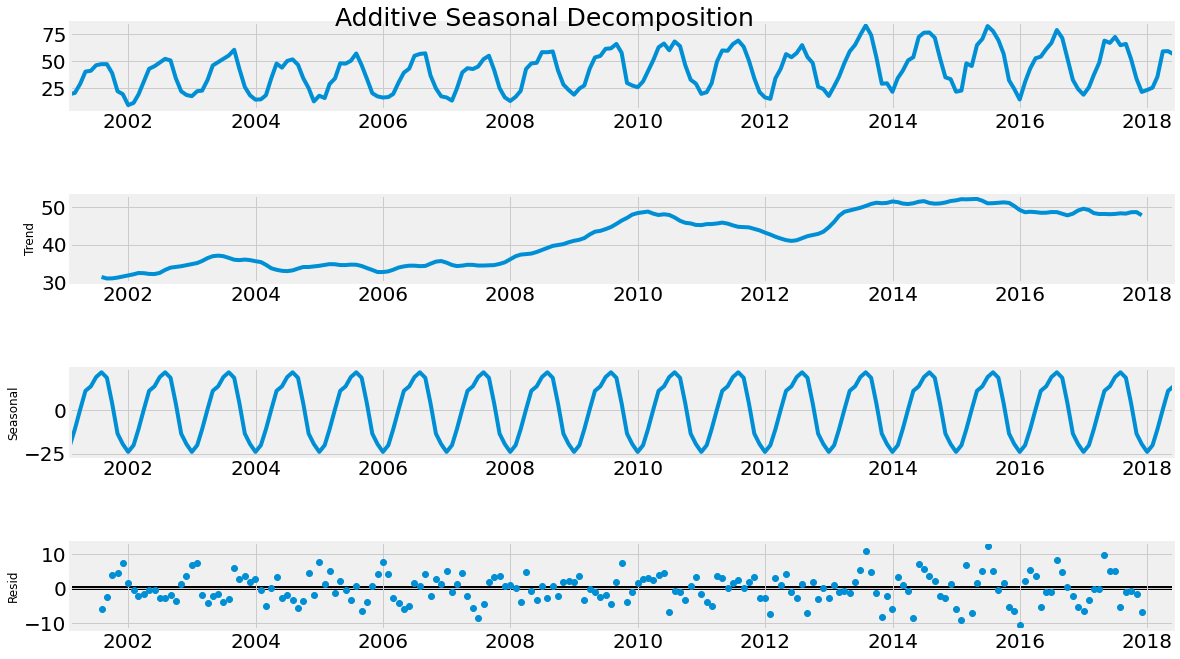

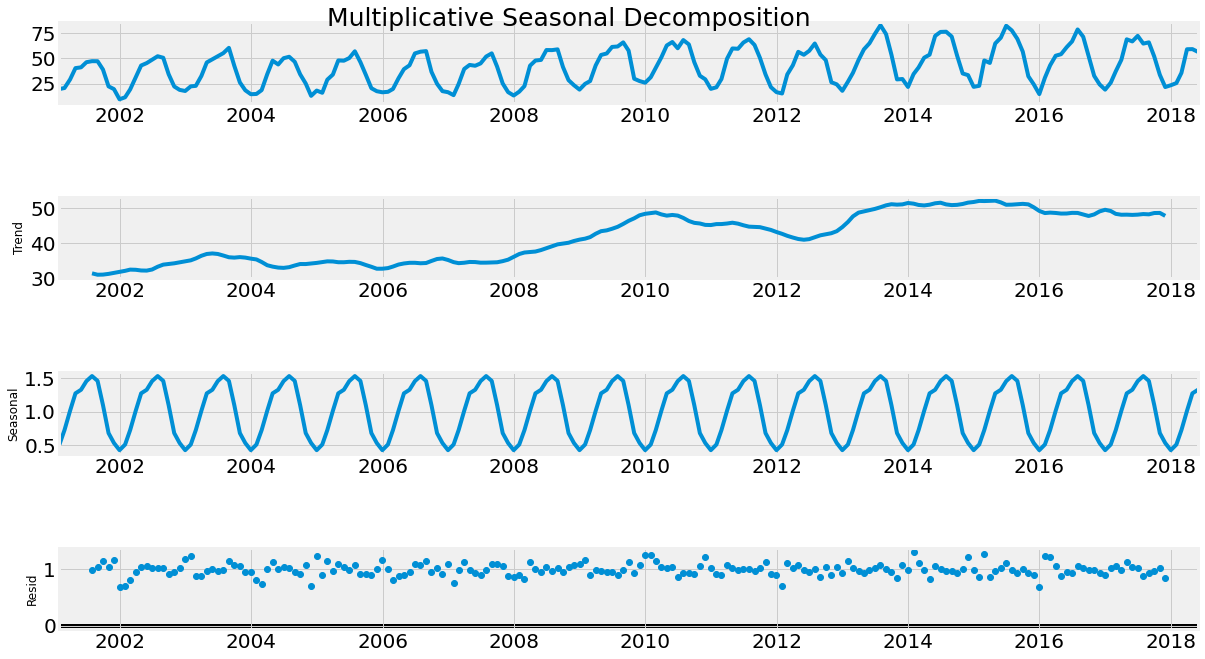

In [20]:
decomposition_df = pd.DataFrame(monthly_df.O_3)
seasonal_a = seasonal_decompose(decomposition_df, model='additive')
seasonal_m = seasonal_decompose(decomposition_df, model='multiplicative')
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=25)
fig_1.set_figheight(10)
fig_1.set_figwidth(20)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=25)
fig_2.set_figheight(10)
fig_2.set_figwidth(20)
plt.show()


<a id='smoothing'></a>
# Smoothing
---

El suavizado es una técnica que podemos utilizar para reducir el ruido en nuestra serie temporal y realizar pronósticos. El pronóstico con técnicas de suavizado como el suavizado exponencial lineal (LES) y el suavizado exponencial simple (SES) puede funcionar para datos no estacionales donde la serie temporal es estacionaria localmente y tiene una tendencia leve. Para series de tiempo más complejas, existen técnicas como los métodos estacionales de Holt-Winters que se basan en técnicas de suavizado simples. No profundizaremos mucho en los métodos de pronóstico de Holt-Winters, pero los presentaremos, presentaremos cómo se relacionan con técnicas más simples y, con suerte, entenderemos cómo pensar en nuestra serie de tiempo como una combinación de componentes y cómo el suavizado afecta la distribución subyacente. de nuestros datos.

Las técnicas de suavizado son fundamentales para las series temporales y se utilizan en varias aplicaciones, incluida la familia ARMA de modelos de pronóstico. Al suavizar, debemos prestar atención a la varianza y la forma de nuestras distribuciones de datos, ya que los modelos excesivamente suavizados pueden mostrar un alto sesgo, y el suavizado puede reducir demasiada varianza según nuestros parámetros.

<a id='sma'></a>
### Simple Moving Average (SMA)
El promedio móvil simple es un promedio igualmente ponderado de n términos de datos. El promedio móvil simple es excelente cuando faltan datos o son muy irregulares. Es primitivo pero robusto. Nuestros datos de contaminantes son increíblemente ruidosos, particularmente en su escala horaria original. SMA es una buena herramienta de preprocesamiento para suavizar gradualmente nuestros datos al nivel que queremos.



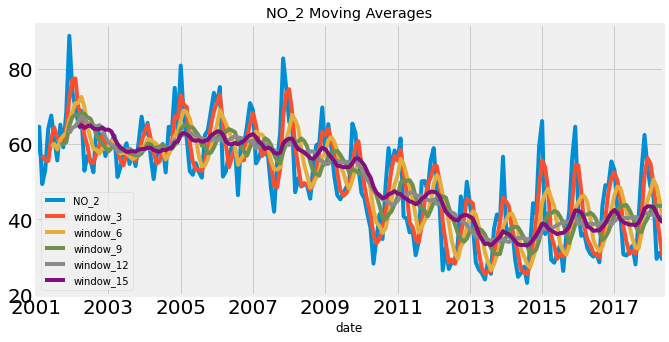

In [21]:
SMA_df= pd.DataFrame(monthly_df.NO_2)
for n in range(1, 6):
    label = 'window_'+str(n*3)
    SMA_df[label] = SMA_df['NO_2'].rolling(window=n*3).mean()

SMA_df.plot(figsize=(10, 5), title='NO_2 Moving Averages')
plt.show()

In [22]:
error = {}
for col in SMA_df.columns[1:]:
    series = SMA_df[['NO_2', col]]
    series = series.dropna(axis=0)
    error[col] = mean_squared_error(series['NO_2'], series[col]) 
    print(f'Moving Average {col} MSE: ', round(error[col], 2))

metadata = {'mean':[], 'variance':[], 'skew':[], 'kurtosis':[]}
for col in SMA_df:
    metadata['mean'].append(SMA_df[col].mean())
    metadata['variance'].append(SMA_df[col].var())
    metadata['skew'].append(SMA_df[col].skew())
    metadata['kurtosis'].append(SMA_df[col].kurt())

Moving Average window_3 MSE:  35.02
Moving Average window_6 MSE:  86.57
Moving Average window_9 MSE:  106.49
Moving Average window_12 MSE:  89.01
Moving Average window_15 MSE:  73.88


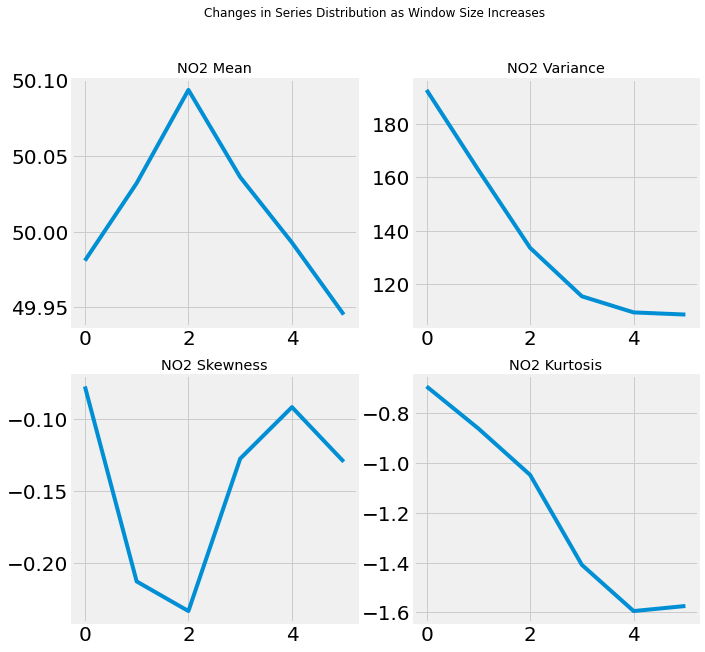

In [23]:
  
plt.figure(figsize=(10,10))
plt.suptitle('Changes in Series Distribution as Window Size Increases')
plt.subplot(221)
plt.title('NO2 Mean')
plt.plot(metadata['mean'])
plt.subplot(222)
plt.title('NO2 Variance')
plt.plot(metadata['variance'])
plt.subplot(223)
plt.title('NO2 Skewness')
plt.plot(metadata['skew'])
plt.subplot(224)
plt.title('NO2 Kurtosis')
plt.plot(metadata['kurtosis'])
plt.show()

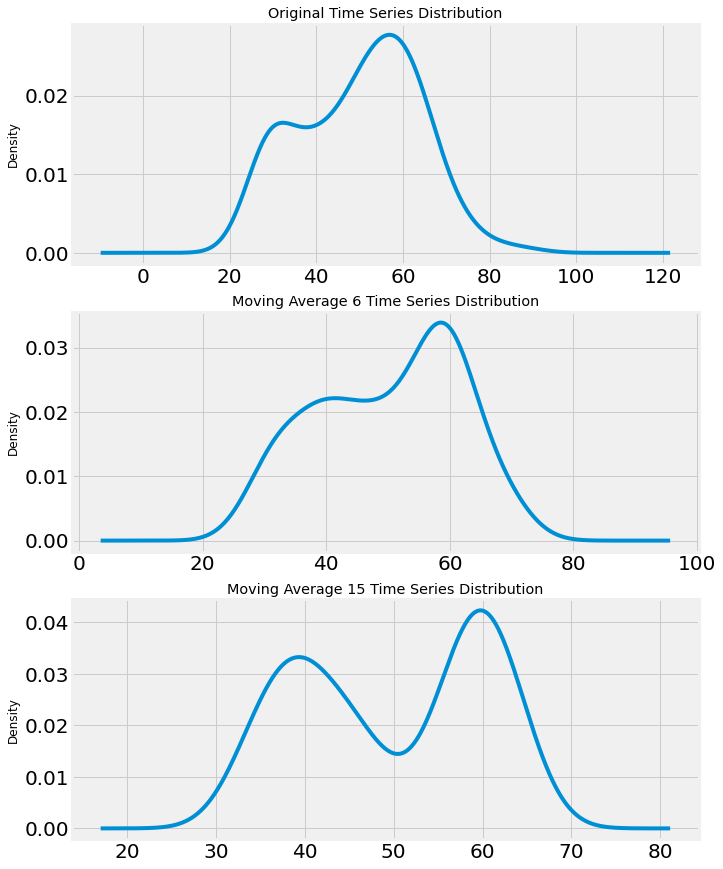

In [24]:



  

plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.title('Original Time Series Distribution')
SMA_df.NO_2.plot(kind='kde')
plt.subplot(312)
plt.title('Moving Average 6 Time Series Distribution')
SMA_df['window_6'].plot(kind='kde')
plt.subplot(313)
plt.title('Moving Average 15 Time Series Distribution')
SMA_df['window_15'].plot(kind='kde')
plt.show()

<a id='exp smoothing'></a>
### Simple Exponential Smoothing (SES)
El suavizado exponencial es un promedio ponderado de n términos de datos pasados, donde los pesos decaen exponencialmente. Podemos usar el suavizado exponencial simple cuando los datos no son estacionales y muestran una media variable en el tiempo sin una tendencia constante. SES es lo mismo que un modelo ARIMA(0, 1, 1) sin una constante estacional. Proporcionamos a SES un valor, alfa, un parámetro de suavizado que controla la velocidad a la que los pesos decaen exponencialmente. Los valores grandes significan que el modelo presta mucha atención a las observaciones pasadas más recientes, y un alfa más pequeño considera una historia mayor.

### Double Exponential Smoothing 

El suavizado exponencial doble es para analizar datos que muestran una tendencia, agrega ecuaciones adicionales al suavizado exponencial simple para capturar el nivel y la tendencia de la serie, utilizando el parámetro beta. El suavizado exponencial doble también se denomina método de tendencia lineal de Holt y en el paquete statsmodels usamos `ExponentialSmoothing` para implementar el suavizado exponencial doble y triple. Al usar el paquete statsmodels todo lo que tenemos que indicar es si la tendencia es aditiva o multiplicativa. Esto se discute más adelante en el núcleo, pero simplemente, la tendencia aditiva y multiplicativa se trata de si la tendencia es consistente o parece crecer, como una función exponencial, por ejemplo. Si la tendencia es consistente entonces es aditiva, si la tendencia crece entonces es multiplicativa. También parte de la implementación de suavizado exponencial de statsmodels es un argumento `amortiguado`. El método lineal de Holt tiende a mostrar una tendencia constante indefinidamente en el futuro. El parámetro `amortiguado` corrige esta tendencia infinita amortiguando la tendencia. Hay un parámetro amortiguado entre 0 y 1 donde los valores más cercanos a 1 son los mismos que en un modelo no amortiguado. Podemos establecer estos parámetros nosotros mismos, pero en la práctica, simplemente establecemos si incluir o no el parámetro amortiguado.

### Triple Exponential Smoothing

Si sus datos muestran tendencia y estacionalidad, el suavizado exponencial triple se basa en las ecuaciones utilizadas en simple y doble y agrega una tercera ecuación para manejar la estacionalidad. También llamado Holt-Winters Exponential Smoothing, un nuevo parámetro, gamma, se utiliza para influir en la estacionalidad. Además, indicamos si la estacionalidad es aditiva o multiplicativa como hicimos con la tendencia.

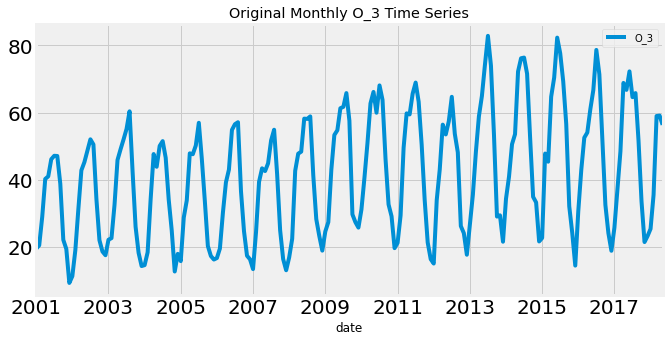

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\pc\AppData\Local\Temp/ipykernel_1108/1023069480.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  es_double = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= None, seasonal_periods= None).fit()
C:\Users\pc\AppData\Local\Temp/ipykernel_1108/1023069480.py:6: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  es_triple = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= 'mul', seasonal_periods= 12).fit()


In [25]:
smoothing_df = pd.DataFrame(monthly_df.O_3)
smoothing_df.plot(figsize=(10, 5), title='Original Monthly O_3 Time Series')
plt.show()
es_simple = SimpleExpSmoothing(smoothing_df.O_3).fit()
es_double = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= None, seasonal_periods= None).fit()
es_triple = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= 'mul', seasonal_periods= 12).fit()

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


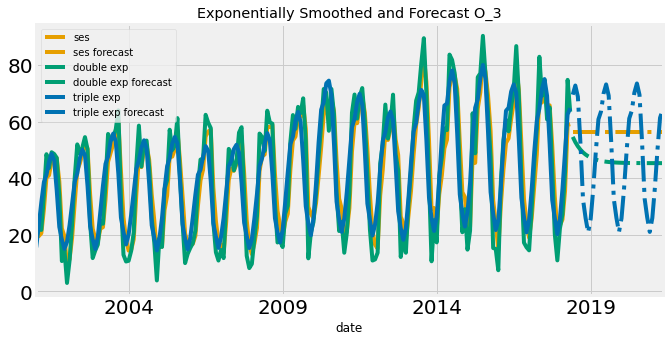

In [26]:
plt.figure(figsize=(10, 5))
es_simple.fittedvalues.plot(color=[(230/255,159/255,0)], legend=True, title='Exponentially Smoothed and Forecast O_3')
es_simple.forecast(36).plot(color=[(230/255,159/255,0)], style='-.')
es_double.fittedvalues.plot(color=[(0,158/255,115/255)])
es_double.forecast(36).plot(color=[(0,158/255,115/255)], style='-.')
es_triple.fittedvalues.plot(color=[(0,114/255,178/255)])
es_triple.forecast(36).plot(color=[(0,114/255,178/255)], style='-.')

plt.legend(['ses', 'ses forecast', 'double exp', 'double exp forecast', 
            'triple exp', 'triple exp forecast'])
plt.show()

In [27]:




smoothing_df['simple_es'] = es_simple.fittedvalues
smoothing_df['double_es'] = es_double.fittedvalues
smoothing_df['triple_es'] = es_triple.fittedvalues
print('Simple Exponential Smoothing MSE: ', round(es_simple.sse/len(es_simple.fittedvalues), 2))
print('Double Exponential Smoothing MSE: ', round(es_double.sse/len(es_double.fittedvalues), 2))
print('Triple Exponential Smoothing MSE: ', round(es_triple.sse/len(es_triple.fittedvalues), 2))


Simple Exponential Smoothing MSE:  104.3
Double Exponential Smoothing MSE:  83.35
Triple Exponential Smoothing MSE:  17.93


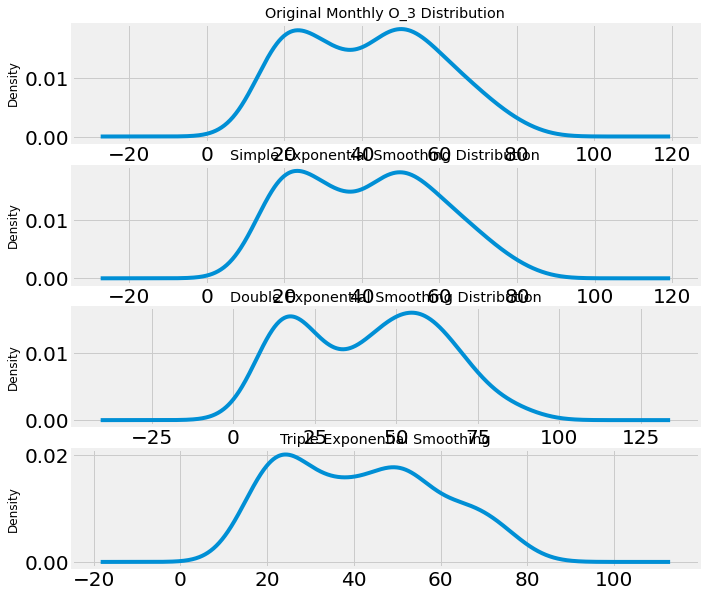

In [28]:

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.title('Original Monthly O_3 Distribution')
smoothing_df.O_3.plot(kind='kde')
plt.subplot(412)
plt.title('Simple Exponential Smoothing Distribution')
smoothing_df['simple_es'].plot(kind='kde')
plt.subplot(413)
plt.title('Double Exponential Smoothing Distribution')
smoothing_df['double_es'].plot(kind='kde')
plt.subplot(414)
plt.title('Triple Exponential Smoothing')
smoothing_df['triple_es'].plot(kind='kde')
plt.show()

<a id='hpf'></a>
### Hodrick-Prescott Filter (HPF)
The Hodrick-Prescott Filter is a data-filtering technique for dealing with business cycles from economic data. Unfortunatley our data in this kernel is not a very good candidate for how to use the Hodrick-Prescott filter but I've included it because its incredibly useful in long-term economic data that often has cycles associated with changes in the market. Business cycles are hard to capture and represent a barrier to stationarity- we can use the Hodrick-Prescott Filter to fix that. HPF tries to decompose the time series into trend and cycle components. The key smoothing parameter we provide is lambda, 1600 is the suggested value for annual data and larger values can be used for more volatile data. 

Other filters that are popular for economic analysis and decomposing cycles are:
* Baxter-King Filter
* Christiano-Fitzgerald Filter

<AxesSubplot:title={'center':'O_3 Pollutant Plot of Cycle and Trend'}, xlabel='date'>

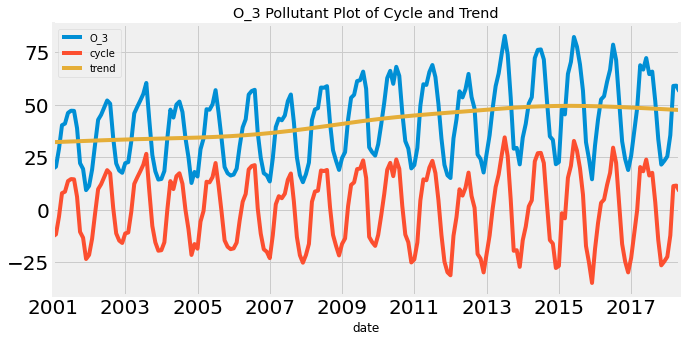

In [29]:
filter_df = pd.DataFrame(monthly_df.O_3)
O3_cycle, O3_trend = hpfilter(filter_df, lamb=129600)
filter_df['cycle'] = O3_cycle
filter_df['trend'] = O3_trend

filter_df.plot(figsize=(10, 5), title='O_3 Pollutant Plot of Cycle and Trend')